In [6]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets

import matplotlib.pyplot as plt

import sys
sys.path.append("../")

from simulationmodel import *
from sampling_utils import *


# Loading MNIST data
train = datasets.MNIST("../", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
trainset = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)

test = datasets.MNIST("../", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
testset = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True)

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def compute_accuracy(model):
    model.eval()
    accurate = 0
    total = 0
    with torch.no_grad():
        for X, y in testset:
            pred_dist = model(X.view(-1, 28*28))
            pred_y = torch.argmax(pred_dist, dim=-1)
            accurate += torch.sum(pred_y==y).numpy()
            total += y.shape[0]
    
    return round(accurate/total*100, 1)

def truncate_quantile(model, q_):
    model.eval()
    for layer in model.hidden_layers:
        q = np.quantile(np.sqrt(layer.get_variances().detach().numpy()), q_)
        layer.trunc_eps = q
        
    q = np.quantile(np.sqrt(model.output_layer.get_variances().detach().numpy()), q_)
    model.output_layer.trunc_eps = q
    
def transform_normal(model):
    model.eval()
    for layer in model.hidden_layers:
        if layer.var_dist.is_static:
            w = np.sum(layer.weight.detach().numpy()**2, axis=0).reshape(1,-1)
            layer.transformed_variances.data = layer.transformed_variances.data * w
            w[w==0] = 1
            layer.weight.data = layer.weight.data / np.sqrt(w)
    
    layer = model.output_layer
    if layer.var_dist.is_static:
        w = np.sum(layer.weight.detach().numpy()**2, axis=0).reshape(1,-1)
        layer.transformed_variances.data = layer.transformed_variances.data * w
        w[w==0] = 1
        layer.weight.data = layer.weight.data / np.sqrt(w)  
    

## Accuracy of the models

In [8]:
# Load trained models
p_list = [500, 1000, 2000]
p_list = [2000]
folder = "results_h_3"
n_runs = 5

n_acc = []
tn_acc = []
h_acc = []
g_acc = []
gl_acc = []
gm_acc = []
p_list_ = []

for r in range(1, n_runs+1):
    for p in tqdm(p_list):
        p_list_.append(p)
        
        folder = "../trained_models/results_h_3"
        normal_net = torch.load('{}/normal_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        n_acc.append(compute_accuracy(normal_net))

        transform_normal(normal_net)
        tn_acc.append(compute_accuracy(normal_net))

        folder = "../trained_models/results_h_3_corrected"
        horseshoe_net = torch.load('{}/horseshoe_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        gbfry_heavy_net = torch.load('{}/gbfry_heavy_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        gbfry_light_net = torch.load('{}/gbfry_light_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        gbfry_mid_net = torch.load('{}/gbfry_mid_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        
        h_acc.append(compute_accuracy(horseshoe_net))
        g_acc.append(compute_accuracy(gbfry_heavy_net))
        gl_acc.append(compute_accuracy(gbfry_light_net))
        gm_acc.append(compute_accuracy(gbfry_mid_net))

    
results = pd.DataFrame.from_dict({
    "p": p_list_,
    "transformed_normal": tn_acc,
    "normal": n_acc,
    "horseshoe": h_acc,
    'gbfry_heavy': g_acc,
    'gbfry_mid': gm_acc,
    'gbfry_light': gl_acc
})

100%|██████████| 1/1 [00:32<00:00, 32.99s/it]


In [5]:
# Results
print("Mean of 5 runs:")
print(results.groupby('p').mean())
print()
results.groupby('p').mean().to_latex("mnist_latex/full_mean.txt")

print("Std of 5 runs:")
print(results.groupby('p').std())
results.groupby('p').std().to_latex("mnist_latex/full_std.txt")

Mean of 5 runs:
      transformed_normal  normal  horseshoe  gbfry_heavy  gbfry_mid  \
p                                                                     
500                97.90   97.90      98.08        97.94      98.02   
1000               97.78   97.78      98.06        97.94      98.06   
2000               97.44   97.44      98.02        98.00      97.84   

      gbfry_light  
p                  
500         98.08  
1000        97.92  
2000        97.94  

Std of 5 runs:
      transformed_normal    normal  horseshoe  gbfry_heavy  gbfry_mid  \
p                                                                       
500             0.141421  0.141421   0.083666     0.151658   0.083666   
1000            0.083666  0.083666   0.114018     0.054772   0.114018   
2000            0.054772  0.054772   0.192354     0.070711   0.089443   

      gbfry_light  
p                  
500      0.130384  
1000     0.238747  
2000     0.089443  


## Truncating the models

In [9]:
q_list = [.5, .8, .9, .95, .98, .985, .99]
folder = "results_h_3"

results = {}

for p in [2000]:#[500, 1000, 2000]:
    n_acc = []
    h_acc = []
    g_acc = []
    gl_acc = []
    gm_acc = []
    ggp_acc = []
    trunc_list = []
    
    for r in range(1, n_runs+1):
        folder = "../trained_models/results_h_3"
        normal_net = torch.load('{}/normal_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        transform_normal(normal_net)

        folder = "../trained_models/results_h_3_corrected"
        horseshoe_net = torch.load('{}/horseshoe_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        
        gbfry_heavy_net = torch.load('{}/gbfry_heavy_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        
        gbfry_light_net = torch.load('{}/gbfry_light_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        
        gbfry_mid_net = torch.load('{}/gbfry_mid_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        
        folder =  '../trained_models/results_ggp'
        ggp_heavy_net = torch.load('{}/ggp_heavy_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        

        for q in tqdm(q_list):
            truncate_quantile(normal_net, q)
            truncate_quantile(horseshoe_net, q)
            truncate_quantile(gbfry_heavy_net, q)
            truncate_quantile(gbfry_light_net, q)
            truncate_quantile(gbfry_mid_net, q)
            truncate_quantile(ggp_heavy_net, q)

            n_acc.append(compute_accuracy(normal_net))
            h_acc.append(compute_accuracy(horseshoe_net))
            g_acc.append(compute_accuracy(gbfry_heavy_net))
            gl_acc.append(compute_accuracy(gbfry_light_net))
            gm_acc.append(compute_accuracy(gbfry_mid_net))
            ggp_acc.append(compute_accuracy(ggp_heavy_net))
            
            trunc_list.append(q*100)
        
       
    results[p] = pd.DataFrame.from_dict({
        "truncation": trunc_list,
        "normal": n_acc,
        "horseshoe": h_acc,
        'gbfry_heavy': g_acc,
        'gbfry_light': gl_acc,
        'gbfry_mid': gm_acc,
        'ggp': ggp_acc,
    })

    print("Results with p = {}".format(p))
    print(results[p].groupby('truncation').mean())
    print(results[p].groupby('truncation').std())
    
    #results[p].groupby('truncation').mean().to_latex("mnist_latex/trunc_mean.txt")
    #results[p].groupby('truncation').std().to_latex("mnist_latex/trunc_std.txt")

100%|██████████| 7/7 [02:50<00:00, 24.38s/it]

Results with p = 2000
            normal  horseshoe  gbfry_heavy  gbfry_light  gbfry_mid    ggp
truncation                                                               
50.0         97.44      97.94        98.00        97.94      97.84  97.98
80.0         95.58      97.94        98.00        97.94      97.84  97.98
90.0         71.70      97.94        98.00        97.94      97.84  97.98
95.0         23.90      97.94        98.00        97.94      97.84  97.98
98.0         12.12      64.22        65.74        61.90      63.22  62.84
98.5         10.36      44.14        50.76        44.46      44.76  45.94
99.0         10.32      26.88        33.82        31.80      28.88  27.10
               normal  horseshoe  gbfry_heavy  gbfry_light  gbfry_mid  \
truncation                                                              
50.0         0.054772   0.089443     0.070711     0.089443   0.089443   
80.0         0.701427   0.089443     0.070711     0.089443   0.089443   
90.0        11.26720

## Feature learning

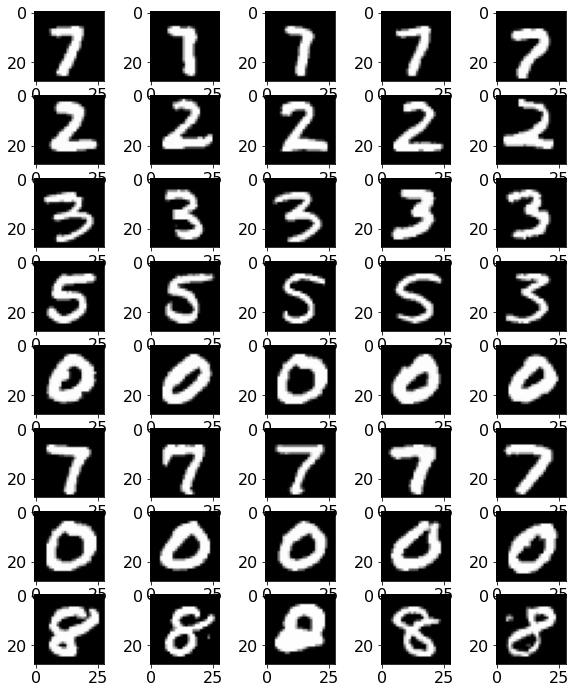

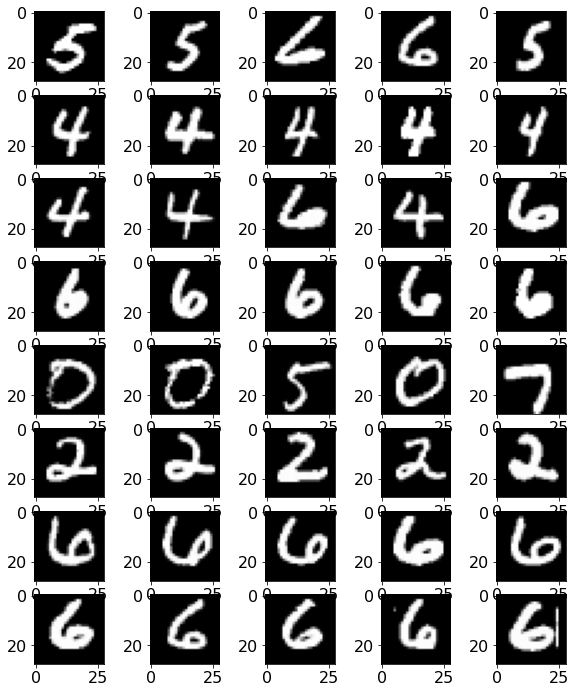

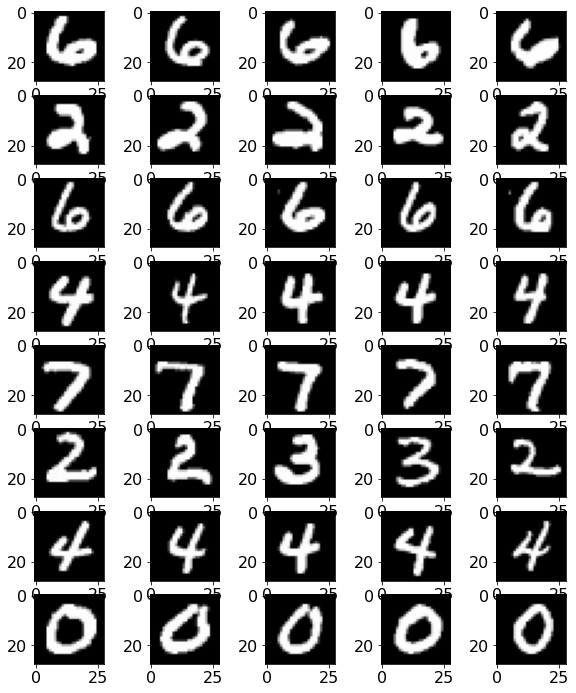

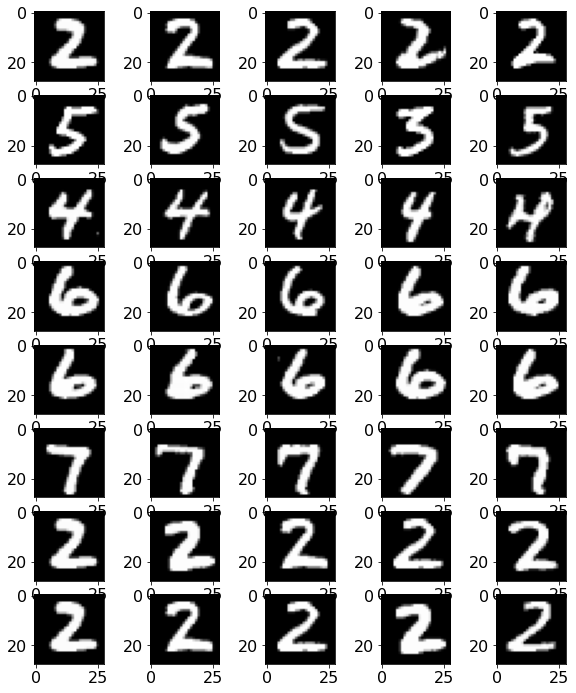

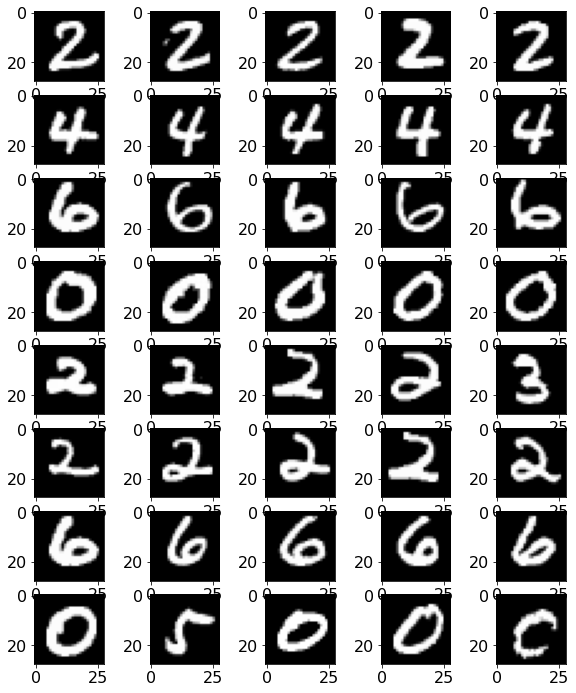

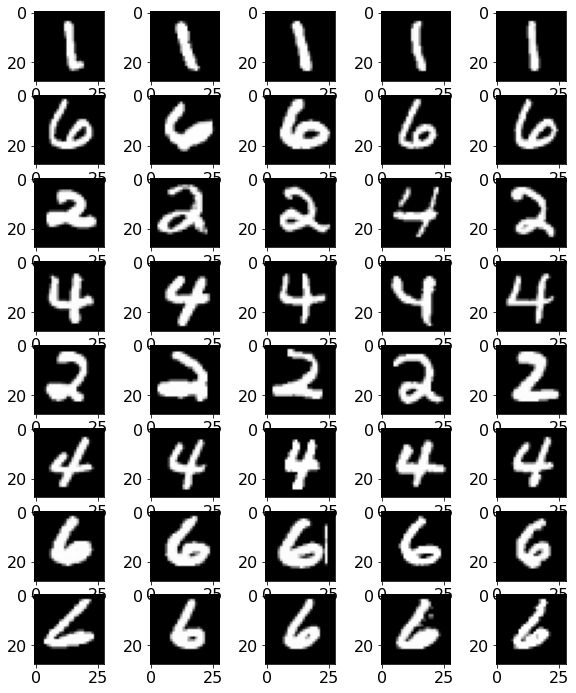

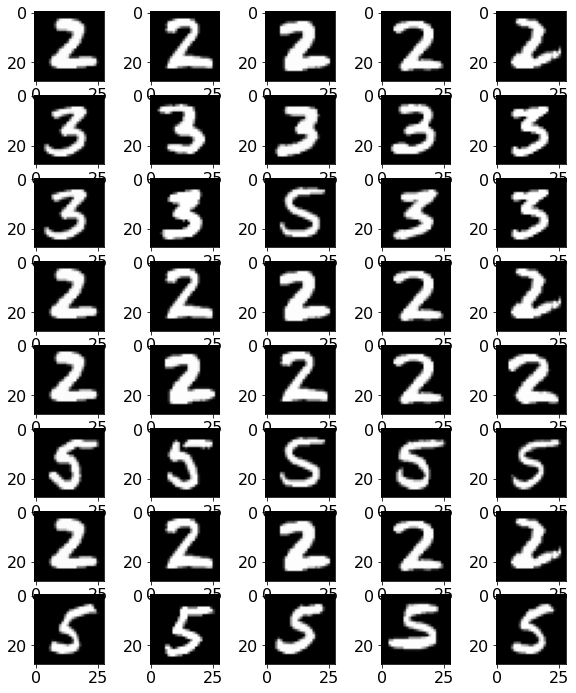

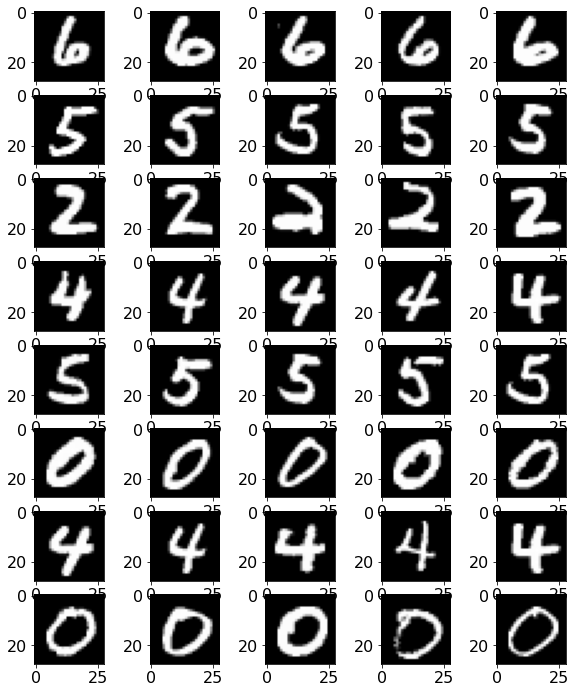

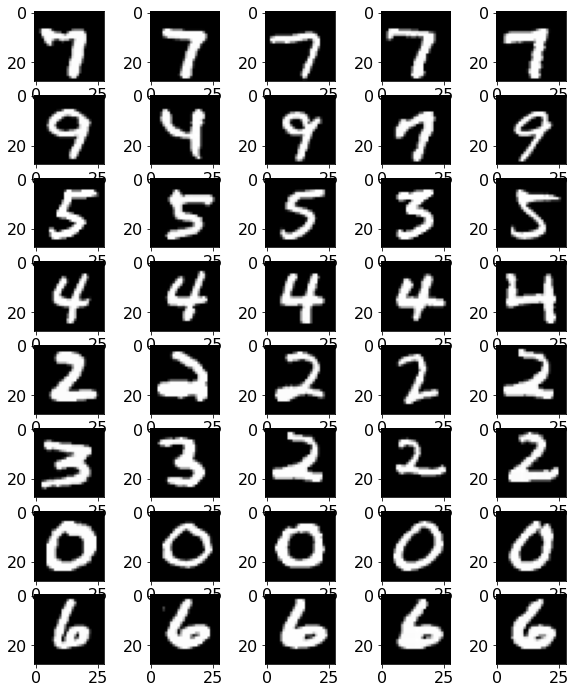

In [18]:
n_figures = 5
n_neurons = 8
folder = "../trained_models/results_h_3_corrected"

largetest = torch.utils.data.DataLoader(test, batch_size=5000, shuffle=True)
X_, Y_ = list(largetest)[0]

# Load trained models
hidden_neurons = [0, 0, 0]

def normal_forward_hook(m, i, o):
    hidden_neurons[0] = o

def horseshoe_forward_hook(m, i, o):
    hidden_neurons[1] = o

def gbfry_forward_hook(m, i, o):
    hidden_neurons[2] = o

for p in [500, 1000, 2000]:
    folder = "../trained_models/results_h_3"
    normal_net = torch.load('{}/normal_ffnn_{}_run_2.net'.format(folder, p)).double().to('cpu').eval()
    transform_normal(normal_net)

    folder = "../trained_models/results_h_3_corrected"
    horseshoe_net = torch.load('{}/horseshoe_ffnn_{}_run_1.net'.format(folder, p)).double().to('cpu').eval()
    gbfry_heavy_net = torch.load('{}/gbfry_heavy_ffnn_{}_run_1.net'.format(folder, p)).double().to('cpu').eval()

    normal_net.hidden_layers[0].register_forward_hook(normal_forward_hook)
    horseshoe_net.hidden_layers[0].register_forward_hook(horseshoe_forward_hook)
    gbfry_heavy_net.hidden_layers[0].register_forward_hook(gbfry_forward_hook)
    

    normal_net(X_.view(-1, 28*28))
    horseshoe_net(X_.view(-1, 28*28))
    gbfry_heavy_net(X_.view(-1, 28*28))

    # Hidden neurons
    normal_neurons = hidden_neurons[0].detach().numpy()
    horseshoe_neurons = hidden_neurons[1].detach().numpy()
    gbfry_neurons = hidden_neurons[2].detach().numpy()

    # Neurons that have the largest impact on the outcome
    normal_idx = np.argsort(normal_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]
    horseshoe_idx = np.argsort(horseshoe_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]
    gbfry_heavy_idx = np.argsort(gbfry_heavy_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]

    # Find the most representative images for each neuron
    features_normal = np.argsort(normal_neurons[:, normal_idx], axis=0)[-n_figures:, :][::-1, :]
    features_horseshoe = np.argsort(horseshoe_neurons[:, horseshoe_idx], axis=0)[-n_figures:, :][::-1, :]
    features_gbfry = np.argsort(gbfry_neurons[:, gbfry_heavy_idx], axis=0)[-n_figures:, :][::-1, :]
    
    # Normal
    plt.subplots(n_neurons, n_figures, figsize=(10, 12))
    for i_ in range(1, n_neurons+1):
        for j_ in range(1, n_figures+1):
            # Compute gradient of the image
            x = copy.deepcopy(X_[features_normal[j_-1, i_-1]])
            x.requires_grad=True
            normal_net(x.view(28*28))
            hidden_neurons[0][i_-1].backward()
            grads = x.grad.detach().abs()
            # Plot most significatif images
            plt.subplot(n_neurons, n_figures, (n_figures*(i_-1)+j_))
            plt.imshow(X_[features_normal[j_-1, i_-1]].detach().view(28,28), cmap="gray")
            #plt.imshow(grads.view(28,28), alpha=0.75, cmap="Reds")
    plt.suptitle("Gaussian prior with p={}".format(p))

    # Horseshoe
    plt.subplots(n_neurons, n_figures, figsize=(10, 12))
    for i_ in range(1, n_neurons+1):
        for j_ in range(1, n_figures+1):
            # Compute gradient of the image
            x = copy.deepcopy(X_[features_horseshoe[j_-1, i_-1]])
            x.requires_grad=True
            horseshoe_net(x.view(28*28))
            hidden_neurons[1][i_-1].backward()
            grads = x.grad.detach().abs()
            # Plot most significatif images
            plt.subplot(n_neurons, n_figures, (n_figures*(i_-1)+j_))
            plt.imshow(X_[features_horseshoe[j_-1, i_-1]].detach().view(28,28), cmap="gray")
            #plt.imshow(grads.view(28,28), alpha=0.75, cmap="Reds")
    plt.suptitle("Horseshoe prior with p={}".format(p))
    
    # BFRY
    plt.subplots(n_neurons, n_figures, figsize=(10, 12))
    for i_ in range(1, n_neurons+1):
        for j_ in range(1, n_figures+1):
            # Compute gradient of the image
            x = copy.deepcopy(X_[features_gbfry[j_-1, i_-1]])
            x.requires_grad=True
            gbfry_heavy_net(x.view(28*28))
            hidden_neurons[2][i_-1].backward()
            grads = x.grad.detach().abs()
            # Plot most significatif images
            plt.subplot(n_neurons, n_figures, (n_figures*(i_-1)+j_))
            plt.imshow(X_[features_gbfry[j_-1, i_-1]].detach().view(28,28), cmap="gray")
            #plt.imshow(grads.view(28,28), alpha=0.75, cmap="Reds")
    plt.suptitle("GBFRY prior with p={}".format(p))

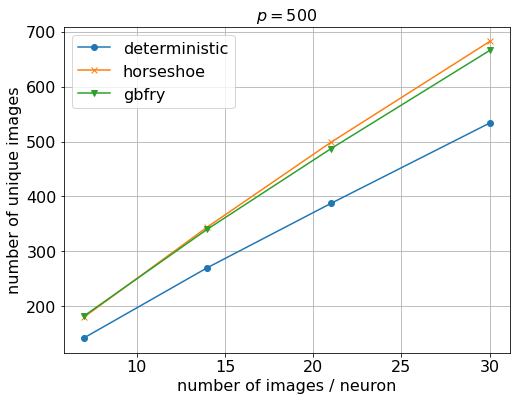

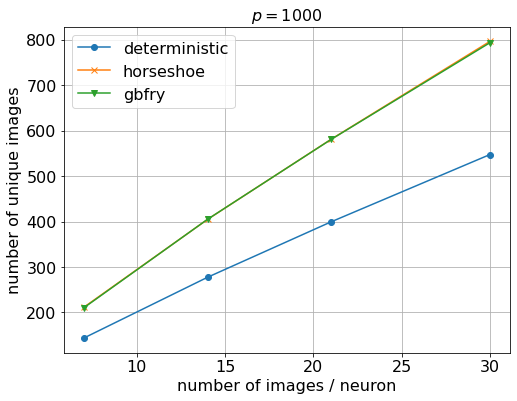

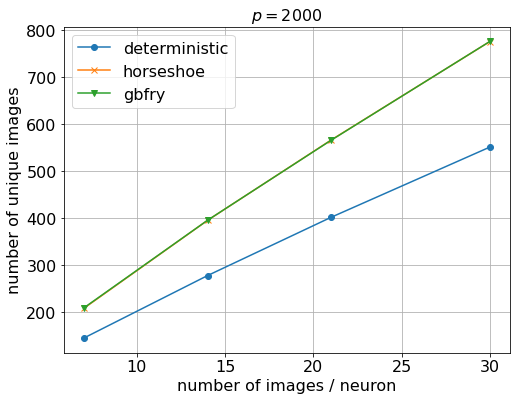

In [16]:
# Plot number of unique images for the top 30 neurons when number of representatives per neuron varies
n_neurons = 30
num_elems = [7, 14, 21, 30]


n_runs = 5

num_uniques_normal = np.zeros(len(num_elems))
num_uniques_horseshoe = np.zeros(len(num_elems))
num_uniques_gbfry = np.zeros(len(num_elems))

for p in [500, 1000, 2000]:
    for r in range(1, n_runs+1):
        folder = "../trained_models/results_h_3"
        normal_net = torch.load('{}/normal_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu').eval()
        transform_normal(normal_net)


        folder = "../trained_models/results_h_3_corrected"
        horseshoe_net = torch.load('{}/horseshoe_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu').eval()
        gbfry_heavy_net = torch.load('{}/gbfry_heavy_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu').eval()

        normal_net.hidden_layers[0].register_forward_hook(normal_forward_hook)
        horseshoe_net.hidden_layers[0].register_forward_hook(horseshoe_forward_hook)
        gbfry_heavy_net.hidden_layers[0].register_forward_hook(gbfry_forward_hook)


        normal_net(X_.view(-1, 28*28))
        horseshoe_net(X_.view(-1, 28*28))
        gbfry_heavy_net(X_.view(-1, 28*28))

        # Hidden neurons
        normal_neurons = hidden_neurons[0].detach().numpy()
        horseshoe_neurons = hidden_neurons[1].detach().numpy()
        gbfry_neurons = hidden_neurons[2].detach().numpy()

        # Neurons that have the largest impact on the outcome
        normal_idx = np.argsort(normal_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]
        horseshoe_idx = np.argsort(horseshoe_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]
        gbfry_heavy_idx = np.argsort(gbfry_heavy_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]

        # Find the most representative images for each neuron
        features_normal = np.argsort(normal_neurons[:, normal_idx], axis=0)
        features_horseshoe = np.argsort(horseshoe_neurons[:, horseshoe_idx], axis=0)
        features_gbfry = np.argsort(gbfry_neurons[:, gbfry_heavy_idx], axis=0)
    
        num_uniques_normal += [
            len(np.unique(features_normal[-n_f:, :])) for n_f in num_elems
        ]
        num_uniques_horseshoe += [
            len(np.unique(features_horseshoe[-n_f:, :])) for n_f in num_elems
        ]
        num_uniques_gbfry += [
            len(np.unique(features_gbfry[-n_f:, :])) for n_f in num_elems
        ]

    num_uniques_normal /= n_runs
    num_uniques_horseshoe /= n_runs
    num_uniques_gbfry /= n_runs
    
    plt.figure(figsize=(8,6))
    plt.title(rf'$p={p}$')
    plt.xlabel('number of images / neuron')
    plt.ylabel('number of unique images')
    markers = ['o', 'x', 'v']
    
    plt.plot(
        num_elems, num_uniques_normal,            
        marker=markers[0],
        label="deterministic"
    )
    plt.plot(
        num_elems, num_uniques_horseshoe,            
        marker=markers[1],
        label="horseshoe"
    )
    plt.plot(
        num_elems, num_uniques_gbfry,            
        marker=markers[2],
        label="gbfry"
    )
    plt.legend()
    plt.grid()
    

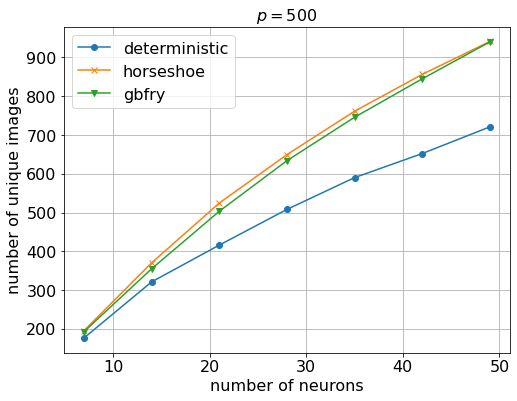

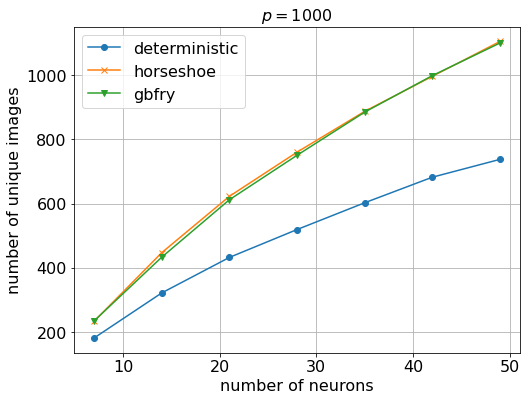

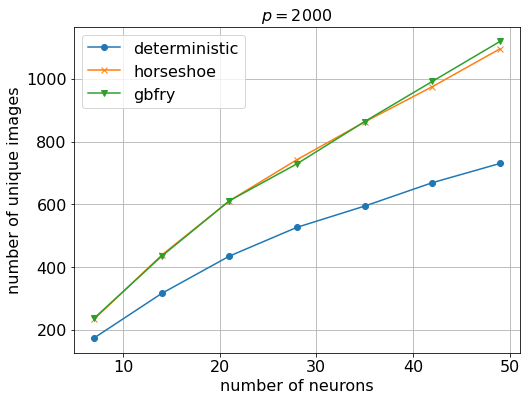

In [17]:
# Plot number of unique images  when number of representatives varies is 30 and the number of the top neurons varies
num_neurons = [7, 14, 21, 28, 35, 42, 49]
n_neurons = np.max(num_neurons)

num_elems = 30

n_runs = 5

num_uniques_normal = np.zeros(len(num_neurons))
num_uniques_horseshoe = np.zeros(len(num_neurons))
num_uniques_gbfry = np.zeros(len(num_neurons))

for p in [500, 1000, 2000]:
    for r in range(1, n_runs+1):
        folder = "../trained_models/results_h_3"
        normal_net = torch.load('{}/normal_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu').eval()
        transform_normal(normal_net)

        folder = "../trained_models/results_h_3_corrected"
        horseshoe_net = torch.load('{}/horseshoe_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu').eval()
        gbfry_heavy_net = torch.load('{}/gbfry_heavy_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu').eval()

        normal_net.hidden_layers[0].register_forward_hook(normal_forward_hook)
        horseshoe_net.hidden_layers[0].register_forward_hook(horseshoe_forward_hook)
        gbfry_heavy_net.hidden_layers[0].register_forward_hook(gbfry_forward_hook)


        normal_net(X_.view(-1, 28*28))
        horseshoe_net(X_.view(-1, 28*28))
        gbfry_heavy_net(X_.view(-1, 28*28))

        # Hidden neurons
        normal_neurons = hidden_neurons[0].detach().numpy()
        horseshoe_neurons = hidden_neurons[1].detach().numpy()
        gbfry_neurons = hidden_neurons[2].detach().numpy()

        # Neurons that have the largest impact on the outcome
        normal_idx = np.argsort(normal_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]
        horseshoe_idx = np.argsort(horseshoe_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]
        gbfry_heavy_idx = np.argsort(gbfry_heavy_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]

        # Find the most representative images for each neuron
        features_normal = np.argsort(normal_neurons[:, normal_idx], axis=0)
        features_horseshoe = np.argsort(horseshoe_neurons[:, horseshoe_idx], axis=0)
        features_gbfry = np.argsort(gbfry_neurons[:, gbfry_heavy_idx], axis=0)
    
        num_uniques_normal += [
            len(np.unique(features_normal[-num_elems:, :n_n])) for n_n in num_neurons
        ]
        num_uniques_horseshoe += [
            len(np.unique(features_horseshoe[-num_elems:, :n_n])) for n_n in num_neurons
        ]
        num_uniques_gbfry += [
            len(np.unique(features_gbfry[-num_elems:, :n_n])) for n_n in num_neurons
        ]
    
    num_uniques_normal /= n_runs
    num_uniques_horseshoe /= n_runs
    num_uniques_gbfry /= n_runs
    
    plt.figure(figsize=(8,6))
    plt.title(rf'$p={p}$')
    plt.xlabel('number of neurons')
    plt.ylabel('number of unique images')
    markers = ['o', 'x', 'v']
    
    plt.plot(
        num_neurons, num_uniques_normal,            
        marker=markers[0],
        label="deterministic"
    )
    plt.plot(
        num_neurons, num_uniques_horseshoe,            
        marker=markers[1],
        label="horseshoe"
    )
    plt.plot(
        num_neurons, num_uniques_gbfry,            
        marker=markers[2],
        label="gbfry"
    )
    plt.legend()
    plt.grid()
    

# WIP (delete)

In [5]:
q_list = [.5, .8, .9, .95, .98, .985, .99]
folder = "../trained_models/results_h_3_corrected"
folder = "../trained_models/results_ggp"
n_runs = 5

results_ggp = {}

for p in [2000]:#[500, 1000, 2000]:
    n_acc = []
    h_acc = []
    g_acc = []
    gl_acc = []
    gm_acc = []
    trunc_list = []
    
    for r in range(1, n_runs+1):
        #ggp_heavy_net = torch.load('{}/gbfry_heavy_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        ggp_light_net = torch.load('{}/ggp_light_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        
        ggp_mid_net = torch.load('{}/ggp_vheavy_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        ggp_heavy_net = torch.load('{}/ggp_heavy_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')

        for q in tqdm(q_list):
            truncate_quantile(ggp_heavy_net, q)
            truncate_quantile(ggp_light_net, q)
            truncate_quantile(ggp_mid_net, q)

            g_acc.append(compute_accuracy(ggp_heavy_net))
            gl_acc.append(compute_accuracy(ggp_light_net))
            gm_acc.append(compute_accuracy(ggp_mid_net))
            trunc_list.append(q*100)
        
       
    results_ggp[p] = pd.DataFrame.from_dict({
        "truncation": trunc_list,
        'ggp_heavy': g_acc,
        'ggp_light': gl_acc,
        'ggp_vheavy': gm_acc,
    })

    print("Results with p = {}".format(p))
    print(results_ggp[p].groupby('truncation').mean())
    print(results_ggp[p].groupby('truncation').std())


100%|██████████| 7/7 [01:22<00:00, 11.72s/it]

Results with p = 2000
            ggp_heavy  ggp_light  ggp_vheavy
truncation                                  
50.0            97.98      97.98       97.88
80.0            97.98      97.98       97.88
90.0            97.98      97.98       97.88
95.0            97.98      97.98       97.88
98.0            62.84      65.70       65.40
98.5            45.94      40.74       49.52
99.0            27.10      22.96       30.46
            ggp_heavy  ggp_light  ggp_vheavy
truncation                                  
50.0         0.083666   0.083666    0.083666
80.0         0.083666   0.083666    0.083666
90.0         0.083666   0.083666    0.083666
95.0         0.083666   0.083666    0.083666
98.0         5.037162   3.120897    8.448373
98.5         4.698723   7.014129   11.810461
99.0         3.687140   6.806100    7.487189


### Maximizer of the hidden layers

100%|██████████| 100/100 [00:01<00:00, 66.38it/s]


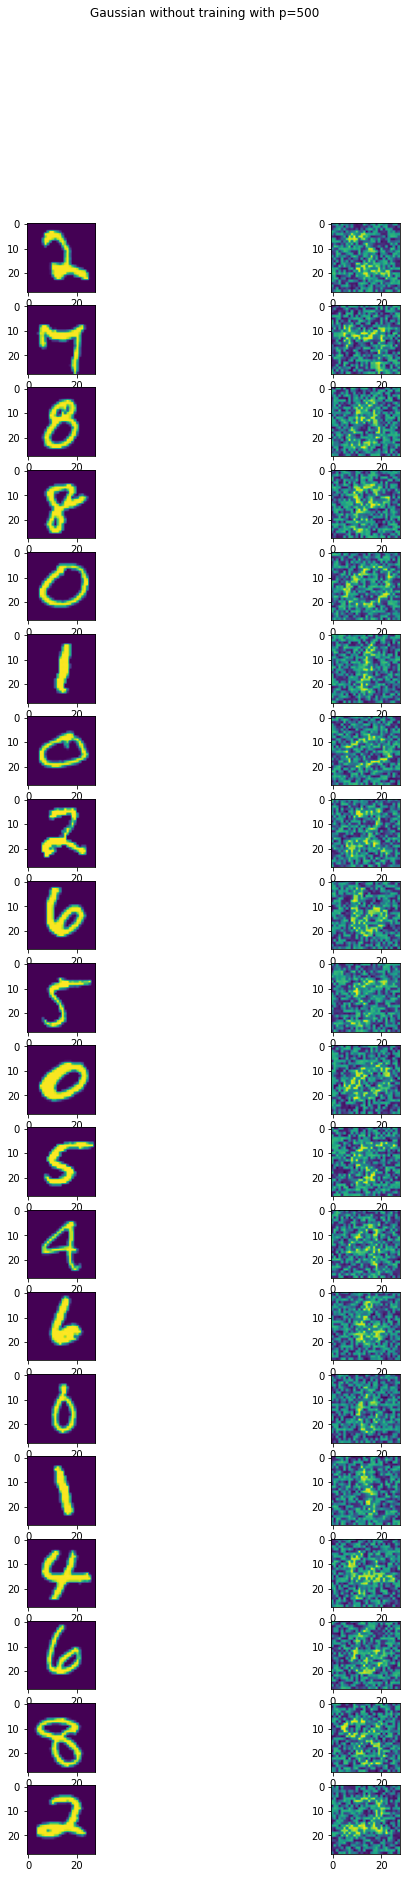

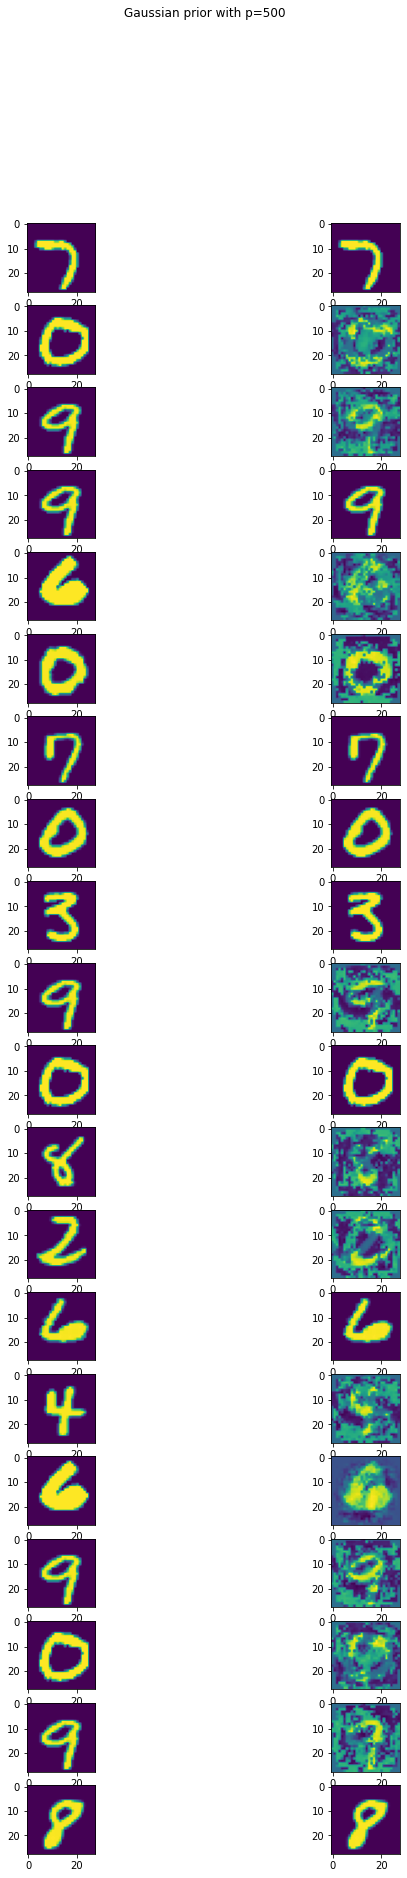

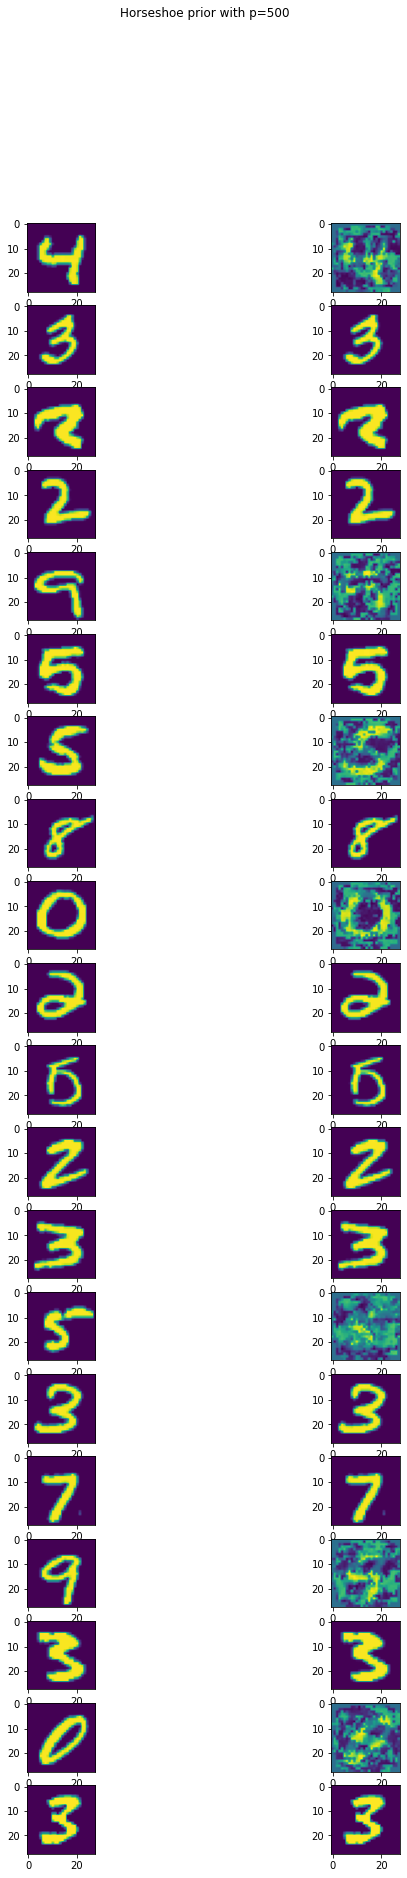

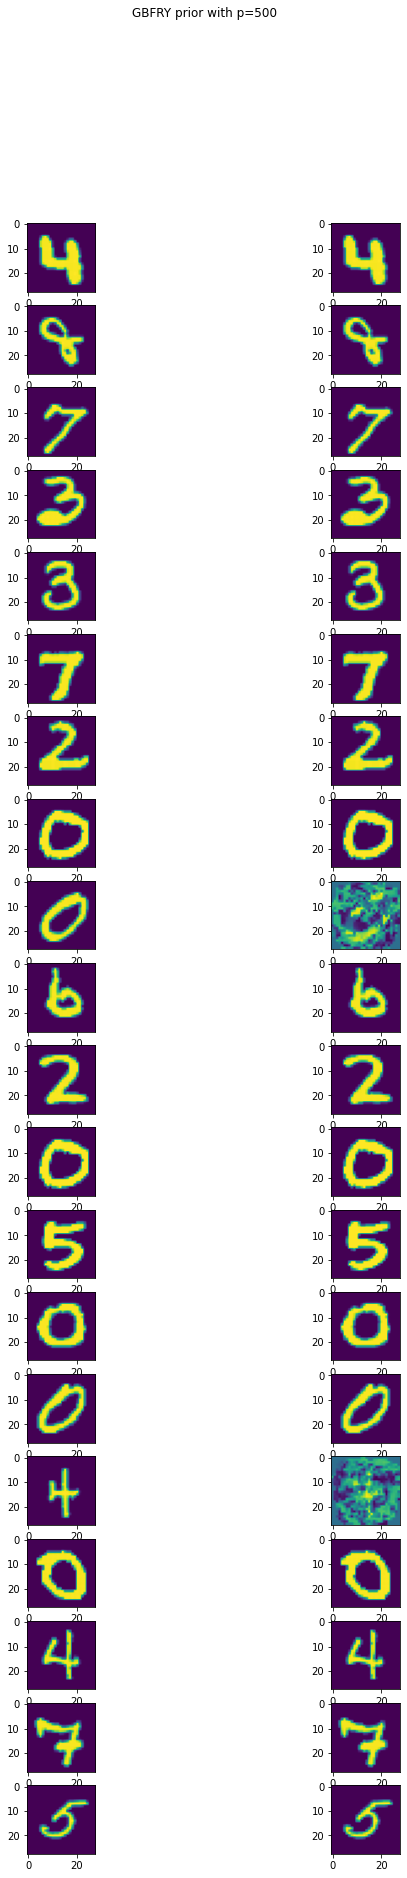

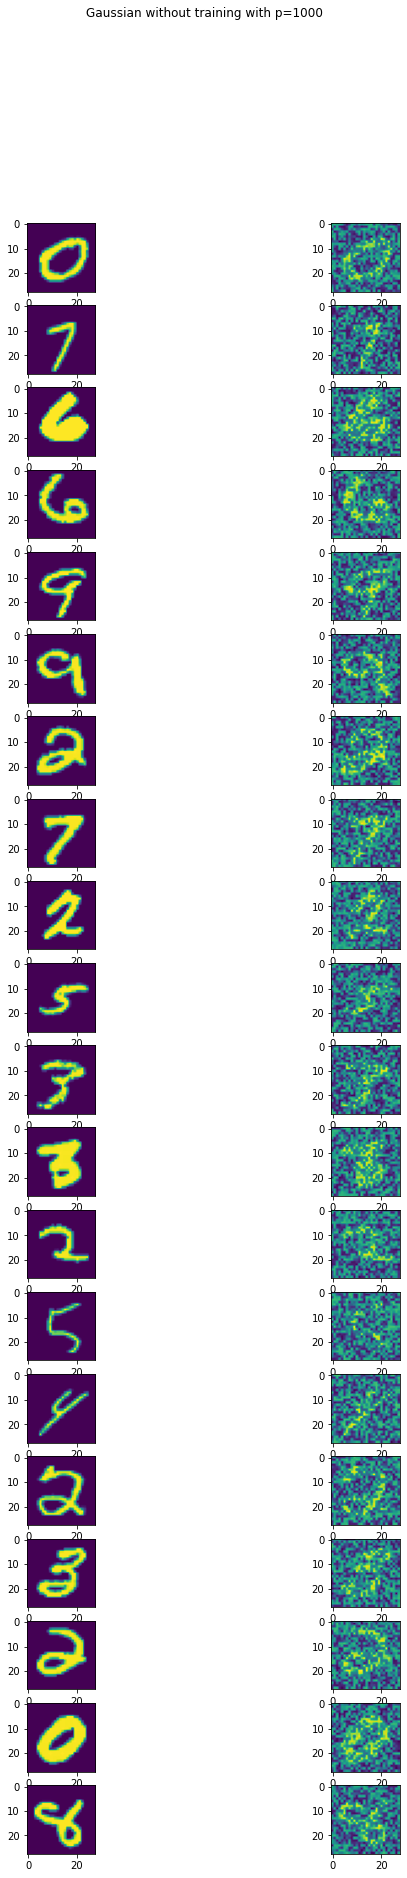

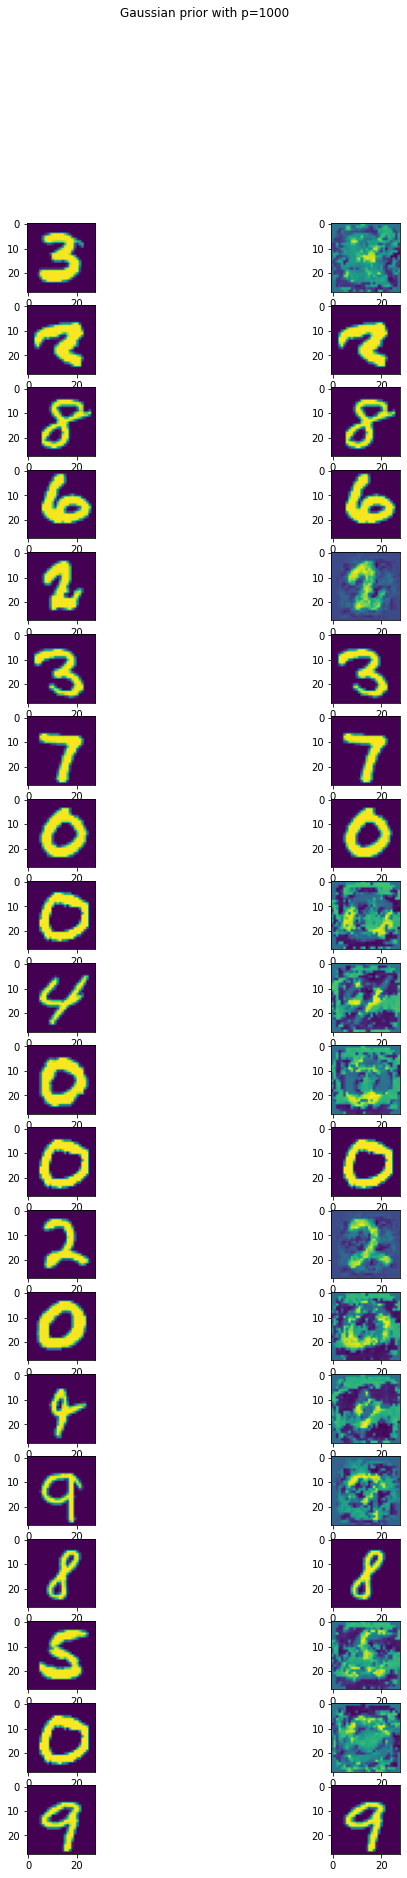

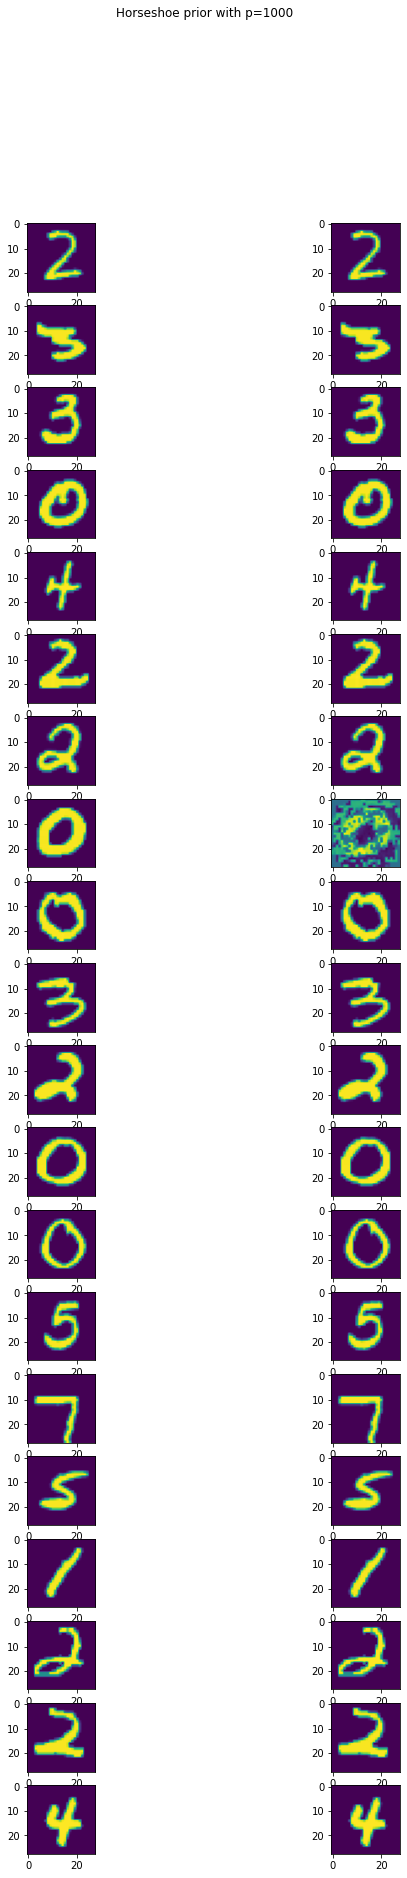

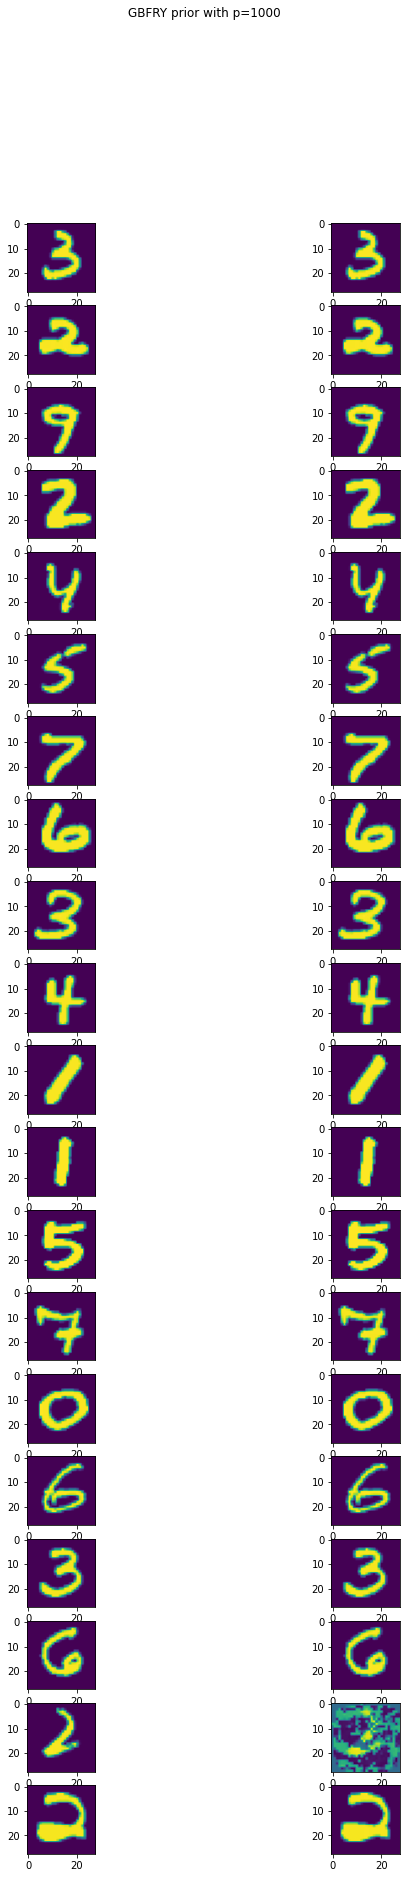

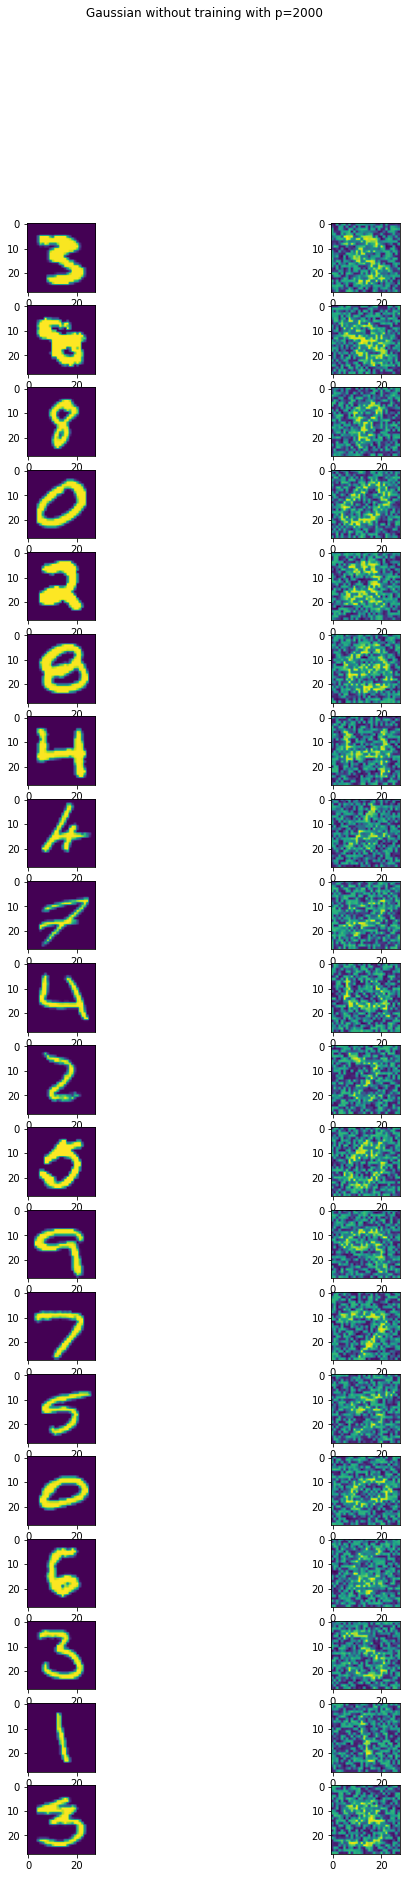

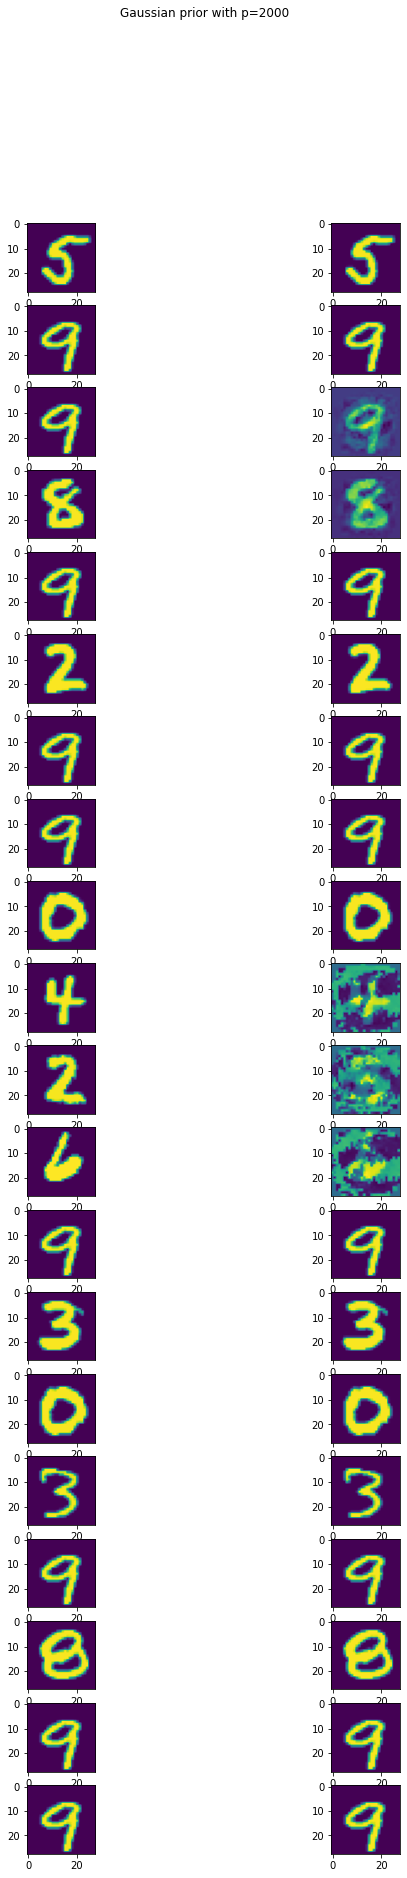

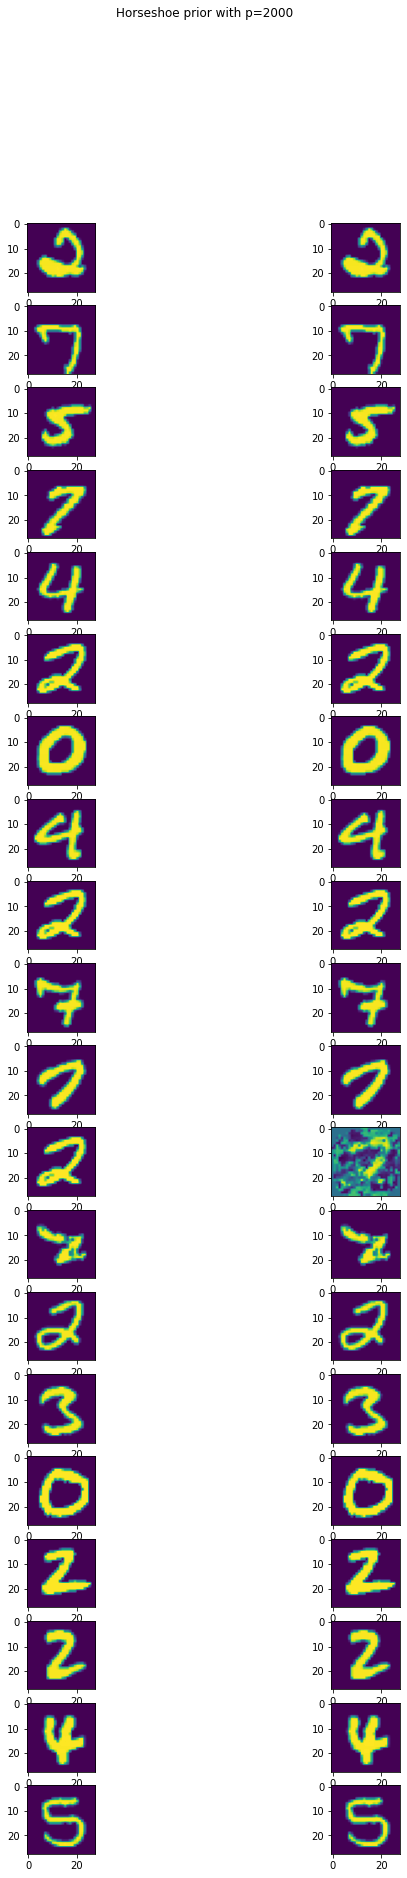

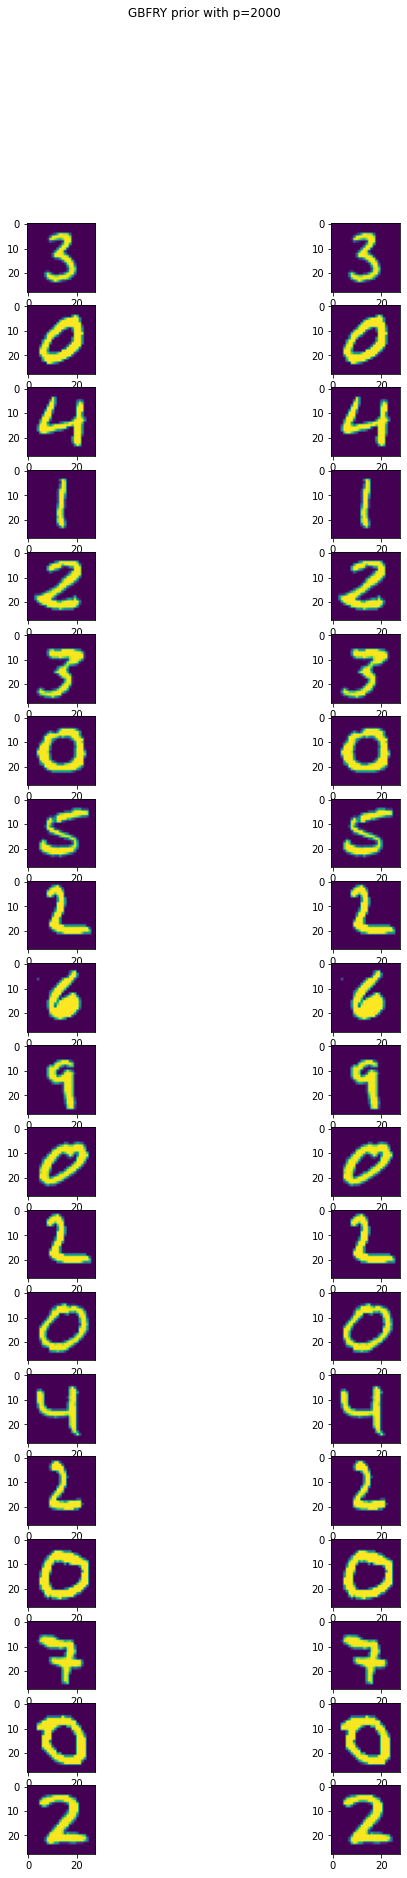

In [98]:
# Architecture of the FFNN
input_size = 28 * 28
num_hidden = 3
output_size = 10

n_figures = 2
n_neurons = 20
figsize = (10, 30)

learning_rate = 1e-2

largetest = torch.utils.data.DataLoader(test, batch_size=5000, shuffle=True)
X_, Y_ = list(largetest)[0]

# Load trained models
hidden_neurons = [0, 0, 0, 0]

epochs = 100

def normal_forward_hook(m, i, o):
    hidden_neurons[0] = o

def horseshoe_forward_hook(m, i, o):
    hidden_neurons[1] = o

def gbfry_forward_hook(m, i, o):
    hidden_neurons[2] = o
    
def baseline_forward_hook(m, i, o):
    hidden_neurons[3] = o

for p in [500, 1000, 2000]:
    baseline_net = BayesFFNN(input_size, num_hidden, p, output_size)
    iid_rvs = lam_dist(p, 'iid')
    # this initialises the weights of the nn
    baseline_net.init_weights(iid_rvs, kappa=1, sigma_b=1)

    transform_normal(baseline_net)
    baseline_net.eval()
    
    normal_net = torch.load('{}/normal_ffnn_{}_run_1.net'.format(folder, p)).double().to('cpu').eval()
    transform_normal(normal_net)
    normal_net.eval()

    horseshoe_net = torch.load('{}/horseshoe_ffnn_{}_run_1.net'.format(folder, p)).double().to('cpu').eval()

    gbfry_heavy_net = torch.load('{}/gbfry_heavy_ffnn_{}_run_1.net'.format(folder, p)).double().to('cpu').eval()

    normal_net.hidden_layers[0].register_forward_hook(normal_forward_hook)
    horseshoe_net.hidden_layers[0].register_forward_hook(horseshoe_forward_hook)
    gbfry_heavy_net.hidden_layers[0].register_forward_hook(gbfry_forward_hook)
    baseline_net.hidden_layers[0].register_forward_hook(baseline_forward_hook)

    normal_net(X_.view(-1, 28*28))
    horseshoe_net(X_.view(-1, 28*28))
    gbfry_heavy_net(X_.view(-1, 28*28))
    baseline_net(X_.view(-1, 28*28))

    # Hidden neurons
    normal_neurons = hidden_neurons[0].detach().numpy()
    horseshoe_neurons = hidden_neurons[1].detach().numpy()
    gbfry_neurons = hidden_neurons[2].detach().numpy()
    baseline_neurons = hidden_neurons[3].detach().numpy()

    # Neurons that have the largest impact on the outcome
    normal_idx = np.argsort(normal_net.output_layer.get_variances().detach().numpy().flatten())[-n_neurons:][::-1]
    horseshoe_idx = np.argsort(horseshoe_net.output_layer.get_variances().detach().numpy().flatten())[-n_neurons:][::-1]
    gbfry_heavy_idx = np.argsort(gbfry_heavy_net.output_layer.get_variances().detach().numpy().flatten())[-n_neurons:][::-1]
    baseline_idx = np.argsort(baseline_net.output_layer.get_variances().detach().numpy().flatten())[-n_neurons:][::-1]

    # Find the most representative images for each neuron
    features_normal = np.argsort(normal_neurons[:, normal_idx], axis=0)[-n_figures:, :][::-1, :]
    features_horseshoe = np.argsort(horseshoe_neurons[:, horseshoe_idx], axis=0)[-n_figures:, :][::-1, :]
    features_gbfry = np.argsort(gbfry_neurons[:, gbfry_heavy_idx], axis=0)[-n_figures:, :][::-1, :]
    features_baseline = np.argsort(baseline_neurons[:, baseline_idx], axis=0)[-n_figures:, :][::-1, :]

    # Baseline
    plt.subplots(n_neurons, n_figures, figsize=figsize)
    for i_ in range(1, n_neurons+1):
        
        # Compute gradient of the image
        j_ = 1
        x = copy.deepcopy(X_[features_baseline[j_-1, i_-1]])
        x.requires_grad=True
        
        # Plot image before gradient descent
        plt.subplot(n_neurons, n_figures, (n_figures*(i_-1)+j_))
        plt.imshow(x.detach().view(28,28))
        
        # Find maximum
        optimizer = torch.optim.Adam([x], lr=learning_rate)
        for _ in tqdm(range(epochs)):
            baseline_net(x.view(28*28))
            loss = -hidden_neurons[3][i_-1]
            
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            optimizer.step()
            
            
        # Plot image after gradient descent
        j_ = 2
        plt.subplot(n_neurons, n_figures, (n_figures*(i_-1)+j_))
        plt.imshow(x.detach().view(28,28))
        
    plt.suptitle("Gaussian without training with p={}".format(p))
    
    # Normal
    plt.subplots(n_neurons, n_figures, figsize=figsize)
    for i_ in range(1, n_neurons+1):
        
        # Compute gradient of the image
        j_ = 1
        x = copy.deepcopy(X_[features_normal[j_-1, i_-1]])
        x.requires_grad=True
        
        # Plot image before gradient descent
        plt.subplot(n_neurons, n_figures, (n_figures*(i_-1)+j_))
        plt.imshow(x.detach().view(28,28))
        
        # Find maximum
        optimizer = torch.optim.Adam([x], lr=learning_rate)
        for _ in tqdm(range(epochs)):
            normal_net(x.view(28*28))
            loss = -hidden_neurons[0][i_-1]
            
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            optimizer.step()
            
            
        # Plot image after gradient descent
        j_ = 2
        plt.subplot(n_neurons, n_figures, (n_figures*(i_-1)+j_))
        plt.imshow(x.detach().view(28,28))
        
    plt.suptitle("Gaussian prior with p={}".format(p))

    # Horseshoe
    plt.subplots(n_neurons, n_figures, figsize=figsize)
    for i_ in range(1, n_neurons+1):

        # Compute gradient of the image
        j_ = 1
        x = copy.deepcopy(X_[features_horseshoe[j_-1, i_-1]])
        x.requires_grad=True
        
        # Plot image before gradient descent
        plt.subplot(n_neurons, n_figures, (n_figures*(i_-1)+j_))
        plt.imshow(x.detach().view(28,28))
        
        # Find maximum
        optimizer = torch.optim.Adam([x], lr=learning_rate)
        for _ in tqdm(range(epochs)):
            
            horseshoe_net(x.view(28*28))
            loss = -hidden_neurons[1][i_-1]
            
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            optimizer.step()
            
        # Plot image after gradient descent
        j_ = 2
        plt.subplot(n_neurons, n_figures, (n_figures*(i_-1)+j_))
        plt.imshow(x.detach().view(28,28))
        
    plt.suptitle("Horseshoe prior with p={}".format(p))
    
    # BFRY
    plt.subplots(n_neurons, n_figures, figsize=figsize)
    for i_ in range(1, n_neurons+1):
        # Compute gradient of the image
        j_ = 1
        x = copy.deepcopy(X_[features_gbfry[j_-1, i_-1]])
        x.requires_grad=True
         
        # Plot image before gradient descent
        plt.subplot(n_neurons, n_figures, (n_figures*(i_-1)+j_))
        plt.imshow(x.detach().view(28,28))
        
        # Find maximum
        optimizer = torch.optim.Adam([x], lr=learning_rate)
        for _ in tqdm(range(epochs)):
            
            gbfry_heavy_net(x.view(28*28))
            loss = -hidden_neurons[2][i_-1]
            
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            optimizer.step()
            
        # Plot image after gradient descent
        j_ = 2
        plt.subplot(n_neurons, n_figures, (n_figures*(i_-1)+j_))
        plt.imshow(x.detach().view(28,28))
        
    plt.suptitle("GBFRY prior with p={}".format(p))

In [96]:
normal_idx

array([ 201, 1742,  529,  643,  333, 1097, 1181,  740, 1453,  402,  711,
       1724, 1026, 1966,  182,  359,  420,  704,  672,  877])

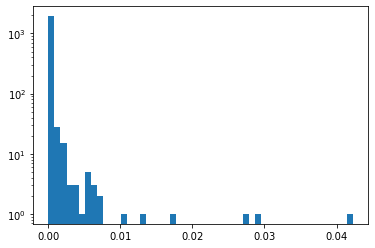

In [171]:
plt.hist(sample_finite_GBFRY(alpha=0.9, tau=5, shape=(1,2000)).flatten(), bins=50, log=True);

In [146]:
all_res = []
for p in [500, 1000, 2000]:
    res = []
    for run in [1, 2, 3, 4, 5]:
        folder = "results_h_3"
        thresh = 0.05

        normal_net = torch.load('{}/normal_ffnn_{}_run_{}.net'.format(folder, p, run)).double().to('cpu').eval()
        variances = normal_net.hidden_layers[0].get_variances().sqrt()
        weights = normal_net.hidden_layers[0].weight
        scaled_weights = (weights*variances).abs().detach().numpy().flatten()
        #plt.hist(scaled_weights)

        print("Number of weights with variance > {} = {}".format(thresh, np.sum(scaled_weights > thresh)))
        print("Largest weight magnitude = {}".format(np.max(scaled_weights)))
        res.append(np.max(scaled_weights))
    all_res.append(res)
    
all_res = np.array(all_res)

Number of weights with variance > 0.05 = 2360
Largest weight magnitude = 0.15559052007961754
Number of weights with variance > 0.05 = 2364
Largest weight magnitude = 0.16112928334052737
Number of weights with variance > 0.05 = 2347
Largest weight magnitude = 0.15616056666173211
Number of weights with variance > 0.05 = 2348
Largest weight magnitude = 0.15068288368914437
Number of weights with variance > 0.05 = 2393
Largest weight magnitude = 0.16790234141608812
Number of weights with variance > 0.05 = 905
Largest weight magnitude = 0.10448737953766236
Number of weights with variance > 0.05 = 872
Largest weight magnitude = 0.12254121798929406
Number of weights with variance > 0.05 = 926
Largest weight magnitude = 0.1247736981511952
Number of weights with variance > 0.05 = 908
Largest weight magnitude = 0.11540498489679836
Number of weights with variance > 0.05 = 943
Largest weight magnitude = 0.12576405539033245
Number of weights with variance > 0.05 = 191
Largest weight magnitude = 0.09

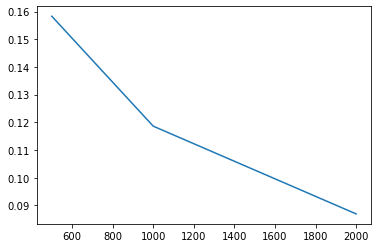

In [147]:
plt.plot(p_list, np.mean(all_res, axis=1))

(array([  6.,  16.,  54.,  97., 145., 442., 141.,  82.,  15.,   2.]),
 array([-8.784993 , -7.1351767, -5.48536  , -3.8355436, -2.1857271,
        -0.5359106,  1.1139059,  2.7637224,  4.413539 ,  6.0633554,
         7.713172 ], dtype=float32),
 <a list of 10 Patch objects>)

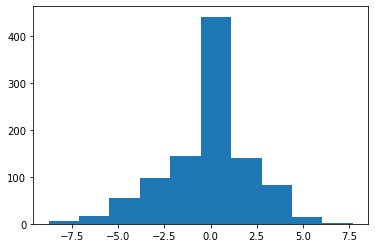

In [126]:
normal_net = torch.load('normal_ffnn_{}.net'.format(100))
plt.hist(normal_net.output_layer.weight.detach().numpy().reshape(-1))

(array([1.42e+03, 3.94e+02, 1.25e+02, 4.10e+01, 1.00e+01, 5.00e+00,
        0.00e+00, 3.00e+00, 1.00e+00, 1.00e+00]),
 array([1.2218380e-06, 8.0975390e-04, 1.6182860e-03, 2.4268180e-03,
        3.2353501e-03, 4.0438822e-03, 4.8524141e-03, 5.6609465e-03,
        6.4694784e-03, 7.2780107e-03, 8.0865426e-03], dtype=float32),
 <a list of 10 Patch objects>)

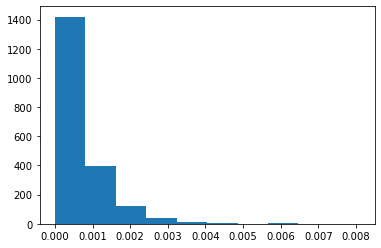

In [121]:
horseshoe_net = torch.load('horseshoe_ffnn_{}_v2.net'.format(2000))
plt.hist(horseshoe_net.output_layer.get_variances().detach().numpy().reshape(-1))

(array([770.,  28.,  31.,  29.,  26.,  26., 320., 577., 171.,  22.]),
 array([-13.615277 , -12.742461 , -11.869645 , -10.996829 , -10.124012 ,
         -9.251196 ,  -8.37838  ,  -7.5055637,  -6.6327477,  -5.759931 ,
         -4.887115 ], dtype=float32),
 <a list of 10 Patch objects>)

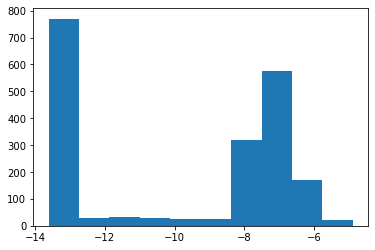

In [123]:
gbfry_heavy_net = torch.load('gbfry_heavy_ffnn_{}_v2.net'.format(2000))
plt.hist(gbfry_heavy_net.output_layer.get_variances().detach().log().numpy().reshape(-1))